In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Generative Learning

The goal of generative models is to learn the probability density function p(x). This probability density effectively describes the behavior of our training data and enables us to generate novel data by sampling from the distribution. Ideally, we want our model to learn a probability p(x) density that will be identical to the density of our data p_data(x).

Note that in most cases, generative models are unsupervised, meaning that they are trained using unlabeled data.

# Latent variable models

Latent variables are a transformation of the data points into a continuous lower-dimensional space.

> In Generative models 'Inference' means: Posterior Estimation. Estimating the hidden (latent) causes (z) that generated the observed data (x).

1. Generation (P(x∣z))
Generation is the process of moving from the latent space (z) to the data space (x).

Goal: To sample a new, realistic data point x (e.g., a new image or text passage).

Mechanism: This is typically handled by the Decoder network in models like VAEs or by the Generator in GANs.

Likelihood: It's represented mathematically by the likelihood or decoding distribution, P(x∣z), which tells you the probability of observing a specific data point x given a latent code z.

2. Inference (P(z∣x))
Inference in the generative context is the reverse: moving from the data space (x) to the latent space (z).

Goal: To find the compressed, underlying representation z (the "code") that most likely produced the observed data x.

Mechanism: This is typically handled by the Encoder network (or the Inference Network) in a VAE.

Posterior Distribution: It's represented mathematically by the posterior distribution, P(z∣x), which tells you the probability of having a specific latent code z given the data x.

The VAE Analogy
In a Variational Autoencoder (VAE), the model is split:

Encoder / Inference Network (Finds z): Takes x and learns to approximate the statistical Inference P(z∣x).

Decoder / Generator Network (Finds x): Takes z and learns the Generation likelihood P(x∣z).

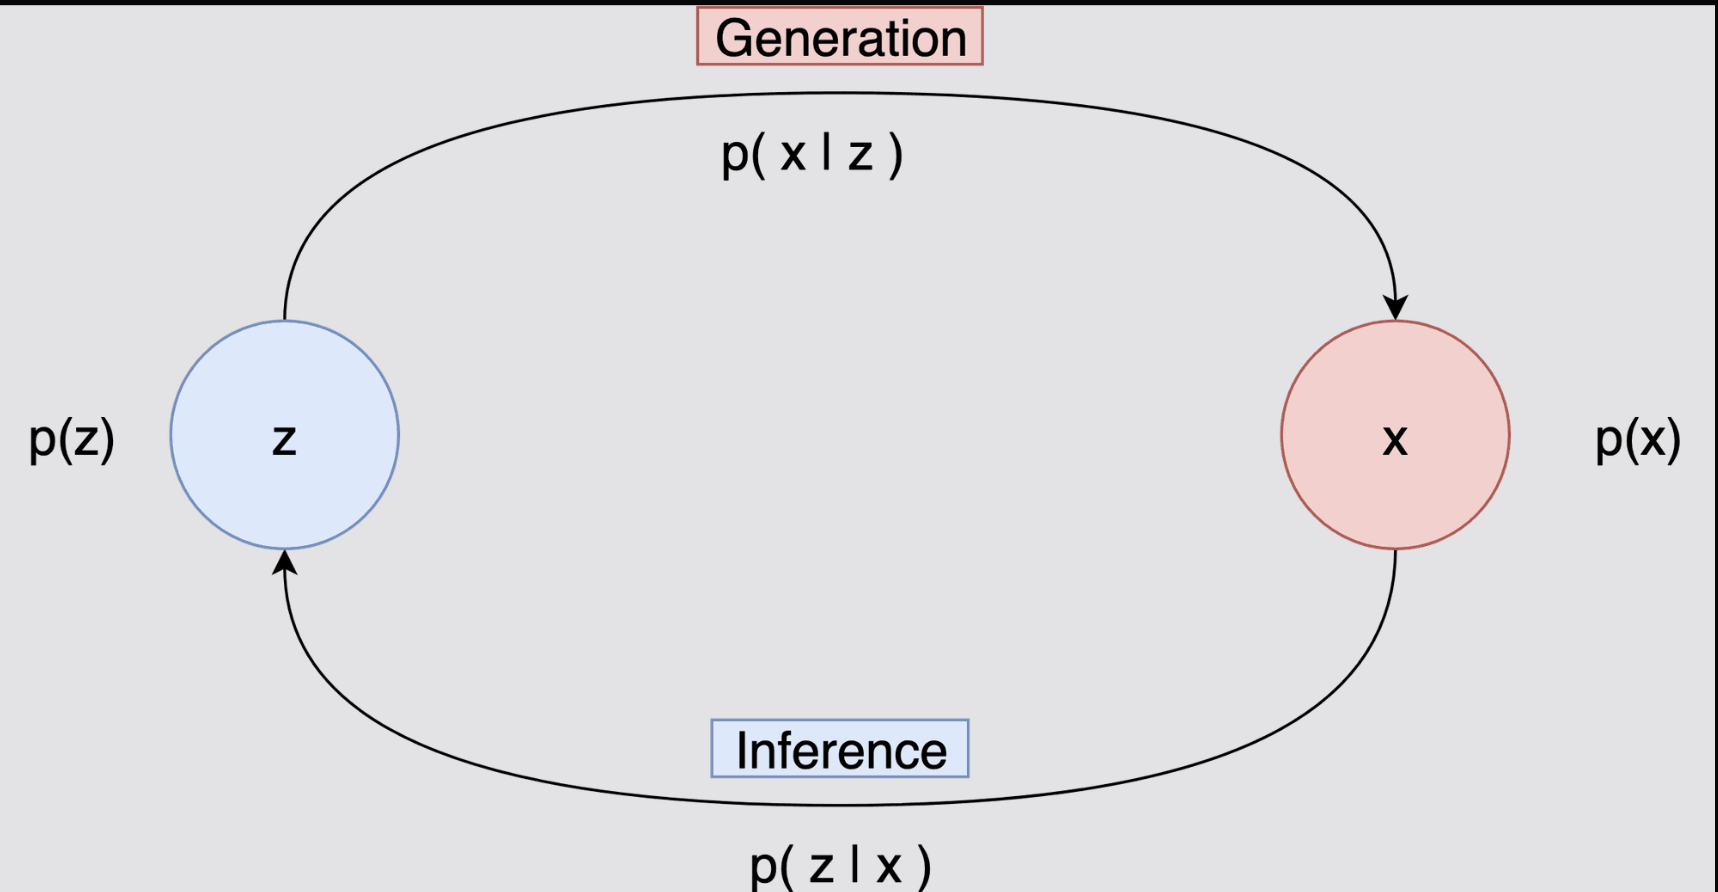

# Basics of Autoencoders

> Autoencoders are simple neural networks such that their output is their input.

Their goal is to learn how to reconstruct the input data.

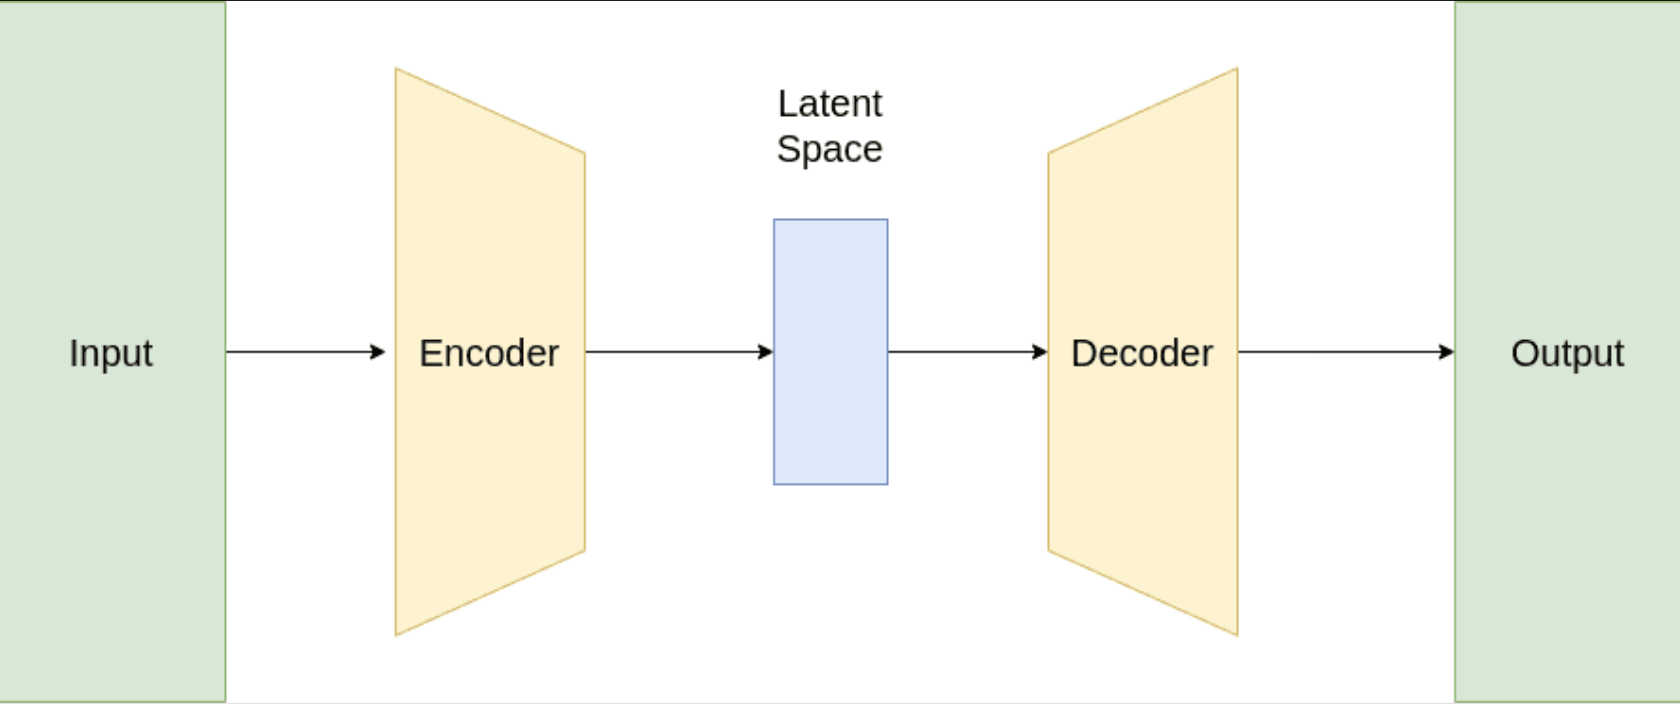

## 🧠 The Autoencoder Concept
An Autoencoder is a network designed to learn a compressed representation (encoding) of its input data. Its training objective is simple: reconstruct its input.

If the network can perfectly reconstruct a complex input (like an image) from a small, constrained code (z), it proves that the code z must contain all the essential information about the input.

## 🧱 The Two-Part Architecture
The Autoencoder is defined by two interconnected parts:

### The Encoder (Compression)
Function: This part of the network receives the original high-dimensional input (x) and compresses it into a lower-dimensional representation.

Output: The latent vector (z), also called the latent code or bottleneck layer.

Latent Space: The text refers to the latent space as a continuous low-dimensional space. This is the compressed feature space where similar inputs are mapped to nearby points. The latent vector z is the desired compressed representation of the input x.

### The Decoder (Decompression/Generation)
Function: This part takes the compressed latent vector (z) and attempts to reconstruct the original high-dimensional input (x).

Training: The loss function (usually Mean Squared Error, MSE) measures the difference between the original input (x) and the decoded output (x_reconstructed). The network trains to minimize this reconstruction error.

## 🎯 Applications of the Latent Vector (z)
The latent vector z is valuable because it isolates the core, independent factors of variation in the data, leading to many practical applications:

### Core Representation Tasks
Compression / Dimensionality Reduction: Once trained, the Decoder can be discarded, and the Encoder is used to transform high-dimensional data into the compact z vector, saving space and computation.

### Practical Novelty Tasks

1. Data Denoising: The network is trained using noisy images as input and clean images as the target output (a Denoising Autoencoder). Because the latent space is low-dimensional, it cannot encode the high-frequency random noise, forcing the Decoder to reconstruct only the learned, clean features.

2. Anomaly Detection: An AE is trained exclusively on data belonging to a single category (e.g., normal machine sensor readings). If the network is fed an anomaly (e.g., a broken sensor reading), it cannot reconstruct it well because it has never seen that type of data. The resulting large reconstruction error signals an anomaly.

3. Training Data Augmentation: By manipulating or sampling new vectors in the latent space and feeding them to the Decoder, you can generate variations of the original training data.

In [2]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
            nn.Conv2d(24, 48, 4, stride=2, padding=1),  # [batch, 48, 4, 4]
            nn.ReLU(),
            nn.Conv2d(48, 96, 4, stride=2, padding=1),  # [batch, 96, 2, 2]
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1),  # [batch, 48, 4, 4]
            nn.ReLU(),
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),  # [batch, 3, 32, 32]
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded

## ConvTranspose2d (Convolutional Transpose 2D)

This is a layer in PyTorch used for upsampling or increasing the spatial resolution of feature maps. It is often referred to as a deconvolution layer, though this term is technically misleading.

Its relationship to Conv2d is that it performs the reverse connectivity pattern of a normal convolution.

ConvTranspose2d works by taking a small input feature map and expanding it into a larger output feature map. It achieves this by performing a convolution operation on a padded, sparsely populated version of the input, effectively distributing each input pixel to a larger receptive field in the output.

Primary Use: Upsampling the spatial dimensions (Height and Width) in the decoder part of models like Autoencoders, VAEs, and Generative Adversarial Networks (GANs).

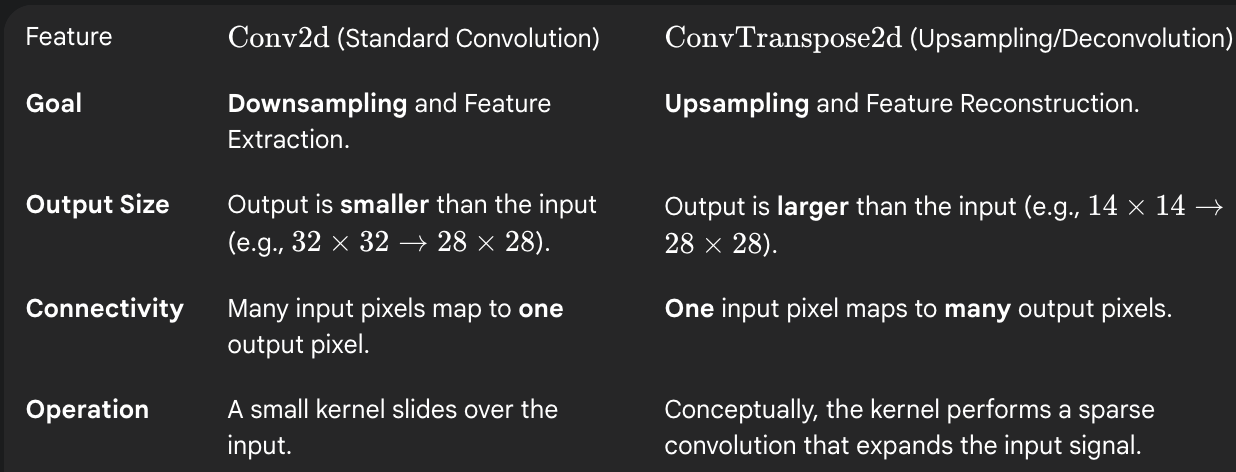